In [1]:
from IPython.display import Image

Итак, у нас многоклассовая классификация.

Одна из частых проблем - перекос классов и эта проблема не обошла и нас стороной

Видим, что представителей 8-10 классов значительно меньше остальных,
из-за чего приходим к мысли, что для метрик качества хорошо может подойти micro агрегирование,
будем считать что вклад пропорционален размеру классов и поэтому маленькими классами можно принебречь и,
соответственно ошибками на них

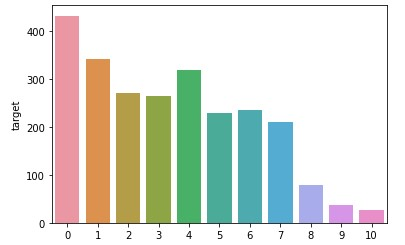

In [2]:
Image(filename='распределение_классов.jpg') 

В eda/11062022_eda_show_text.ipynb был рассмотрен текст и определено содержание категорий

Категория 0: Отсутствие интернета </br>
Категория 1: Падение скорости </br>
Категория 2: Смена пароля </br>
Категория 3: Повреждение оборудования (кабеля) </br>
Категория 4: Пропадает интернет (соединение), телевидение </br>
Категория 5: Узнать пароль от Wi-Fi </br>
Категория 6: Большой пинг, низкая скорость </br>
Категория 7: Настройка роутера </br>
Категория 8: Заменить роутер и приставку </br>
Категория 9: Вызов мастера </br>
Категория 10: Скорее всего категория - Другое </br>

Скорее всего все интенты, которые не получилось качественно категоризовать свалили в одну категорию (10)

Исходя из названий возникает мысль, что некоторые категории будут сильно пересекаться по словам


Просматривая текст, периодически замечаем ошибки, но в целом тексты короткие, поэтому их немного.
Например, "низкая скорость по вай фай серез роутер"

Ошибки наводят на гипотезу, что нам могут помочь н-граммные модели

Просматривая визуально классы, пришел к следующей иерархии классов.
Классы из одной группы скорее всего будут иметь большие проблемы в разделении на классы

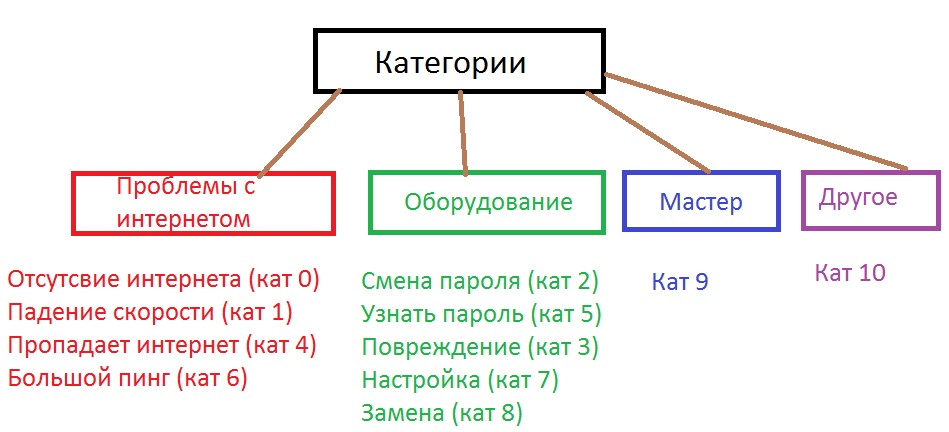

In [3]:
Image(filename='category_hierarchy.jpg') 

Модель проверяется обычным разбиением со стратификацией по классам.
С одной стороны, быстро и по результатам среди данных нет дубликатов текста,
т.е. можно исключить утечки и мы получаем вполне вменяемую точечную оценку.

С другой стороны, более надежной будет интервальная оценка

В целом, выбросов не обнаружил, данные кажутся одной тематики + проблема с вычислительными ресурсами
привели к выбору train/test разбиения вместо K-Fold

В качестве стартовой базовой модели использовалась логистическая регрессия, мультиклассификация.
В качестве признаков - частота встречаемости слов

По матрице ошибок подтверждается проблема с разделением некоторых классов

Наблюдаем - модель путаем много 0 -> 4, 4 -> 0, 0 -> 1

В качестве метрики использовалась Precision (micro)

В итоге, модель показала достаточно высокий скор сходу</br>
(можно посмотреть по хешу в гите параметры эксперимента) </br>
90ceb21f62b6f647ad9c7fab8db533dbc352630a

* Experiment logistic_regression_multiclass, target score: 0.862453531598513


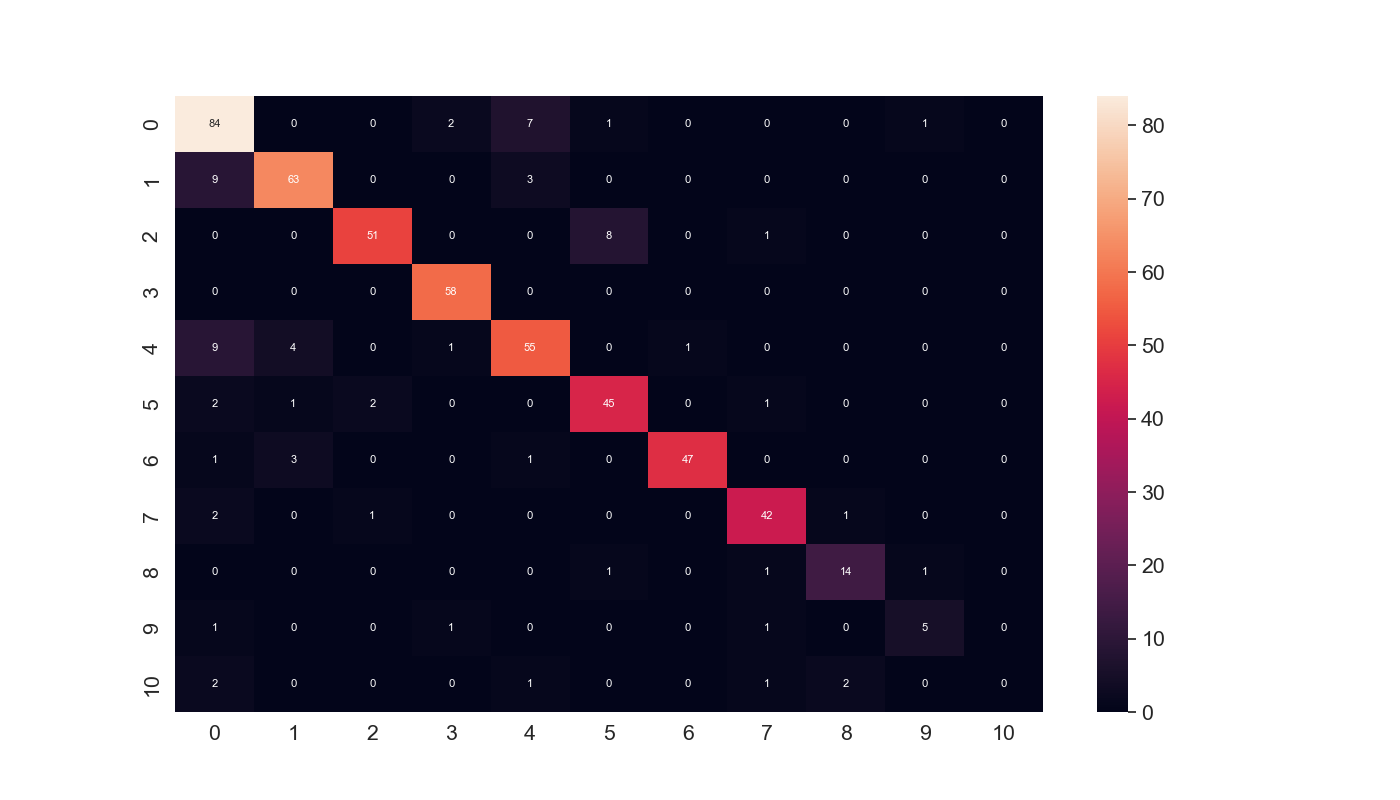

In [7]:
Image(filename='media_images_confusion_matrix_logistic_regression_multiclass_0_9cd306c7d9cb16c6d19e.png')

Далее проверялись следующий гипотезы:
    
    * н-граммы на словах, используем частоту встречаемости
    * символьные н-граммы, используем частоту встречаемости
    * увеличиваем число н-грамм до 7, используем частоту встречаемости
    * н-граммы на словах, используем tfidf
    * символьные н-граммы, используем tfidf
    * увеличиваем число н-грамм до 7, используем tfidf
    * использование предобработки текстов
        * более точная токенизация (razdel)
        * стоп-слова
        
Подробно о всех гипотезах и метриках можно посмотреть здесь https://wandb.ai/trav/rtk_intent_clf </br>
Проект открыт, специальный доступ не нужен, а так же проект на гитхабе (опять же все открыто)

https://github.com/exotol/intent_clf.git

Результаты экспериментов привели к качестве 0.8866171003717472
Модель - логистическая регрессия

 b8fdf1635a95c993a4dff04092e45103cfcd113d

* Experiment log_reg_multiclass_char_wb_ngram_1_7_max_iter_1000, target score: 0.8866171003717472


Странно, но модель плохо работала с векторизацией на TF-IDF, и вполне неплохо работала с частотой

Специального перебора параметров не делал, т.к. данных мало и есть риск переобучиться,
выбирал исходя из эвристик и интуиции.

К примеру, н-граммы взял до 7 на основе средней длины слова (она оказалась 7) по всему набору

В качестве baseline обычно хорошо подходят простые модели на признаках </br>
типа частоты или tf-idf с линейными моделями, поэтому следующей моделью, которую я обычно 
проверяю LinearSVC

На этой модели удалось добиться максимального качества 

SHA-1: 32fc4968edb43851d746d0712b95fef5573b6adc

* Experiment svc_multiclass_crammer_singer_tfidf_char_wb_ngram_1_5, target score: 0.8977695167286245

На TF-IDF признаках SVC сработал очень хорошо

Предобработка текста в виде более точной токенизации и/или стоп-слова не дали улучшений

К несчастью подход с CatBoost'ом провалился - плохое качество.
В качестве признаков использовались подходы для работы с текстам самого CatBoost
Качество примерно 0.8 - 0.86

Дальше было 3 пути: </br>
    * идти по статье https://habr.com/ru/post/669674/ про энкодеры </br>
    * пойти по пути трансформеров и их тюнинга </br>
    * FastText </br>

После рассмотрения статьи становится понятно, что fastText крепкий середнячок для задач русского языка.
Поэтому я взял LaBSE

Модель работает на слабом ПК относительно быстро на CPU, но все равно заметно

Удалось достичь качества 0.8828996282527881</br>
В качестве классификатора SVC.</br>
C логистической регрессией дела обстоят хуже (порядка 0.86) </br>

C Обучением головы здесь сложно, т.к. данных мало, и если даже обучать только голову
очень большой риск переобучиться. Поэтому более сложные головы кажутся здесь не подходящим решением.

Качество неплохое, но ресурсоемкость для моей слабой машины ощутимая

В итоге, наш победитель LinearSVC